In [35]:
import os, shutil, pathlib
from tensorflow import keras
from keras import layers
import numpy as np
import tensorflow as tf
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [127]:
original_dir = pathlib.Path('C:/Users/KSY/Desktop/Codes/AI/Ch_08/data/train/')
new_base_dir = pathlib.Path('cats_vs_dogs_small')

In [128]:
# start_index에서 end_index까지의 고양이와 강아지 이미지를 new_base_dir/{subset_name}/cat(dog)으로 복사
# 유틸리티 함수 subset_name은 train, validation, test 중 하나
def make_subset(subset_name, start_index, end_index) : 
    for category in ('cat', 'dog') :
        dir = new_base_dir / subset_name / category 
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" #0.jpg와 같이 저장되어 있음
                  for i in range(start_index, end_index)]
        for fname in fnames :
            shutil.copyfile(src=original_dir / category / fname, dst=dir / fname) # 중간에 category가 포함

In [130]:
make_subset("train", start_index=0, end_index=1000)

In [131]:
make_subset("validation", start_index=1000, end_index=1500)

In [132]:
make_subset('test', start_index=1500, end_index=2500)

In [7]:
inputs = keras.Input(shape=(180, 180, 3)) # 180 * 180 * 3 크기의 이미지를 기대
x = layers.Rescaling(1./255)(inputs) # 입력을 255로 나누어 0 ~ 1 범위로 조정
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x) # 출력 크기 178, 178, 32
x = layers.MaxPooling2D(pool_size=2)(x) # 출력 크기 89 * 89 * 32
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x) # 출력 크기 87, 87, 64
x = layers.MaxPooling2D(pool_size=2)(x) # 출력 크기 43, 43, 64
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x) # 출력 크기 41, 41, 128
x = layers.MaxPooling2D(pool_size=2)(x) # 출력 크기 20, 20, 128
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x) # 출력 크기 18, 18, 256
x = layers.MaxPooling2D(pool_size=2)(x) # 출력 크기 9, 9, 256
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x) # 출력 크기 7, 7, 256
x = layers.Flatten()(x) # 출력 크기 7 * 7 * 256 = 12,545
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [133]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", # 아래 있는 디렉터리를 class로 가정
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", # 아래 있는 디렉터리를 class로 가정
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [134]:

test_dataset = image_dataset_from_directory(
    new_base_dir / "test", # 아래 있는 디렉터리를 class로 가정
    image_size=(180, 180),
    color_mode='rgb',
    crop_to_aspect_ratio=False,
    batch_size=32)

Found 2000 files belonging to 2 classes.


In [135]:
for data_batch, labels_batch in test_dataset :
    for i in data_batch :
        print(i)

tf.Tensor(
[[[255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  ...
  [ 95.       116.       133.      ]
  [ 96.       115.       132.      ]
  [ 96.       115.       132.      ]]

 [[255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  ...
  [ 95.       116.       133.      ]
  [ 96.       115.       132.      ]
  [ 96.       115.       132.      ]]

 [[255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  ...
  [ 95.       116.       133.      ]
  [ 96.       115.       132.      ]
  [ 96.       115.       132.      ]]

 ...

 [[251.12396  255.       255.      ]
  [252.2427   254.3802   255.      ]
  [249.61806  250.3125   249.96527 ]
  ...
  [ 21.822891  21.822891  19.822891]
  [ 17.371876  17.371876  17.371876]
  [ 15.91217   15.91217   17.251038]]

 [[247.37396  249.58159  250.2118  ]
  [246.63333  248.7604   2

ValueError: x and y can be no greater than 2D, but have shapes (32,) and (32, 180, 180, 3)

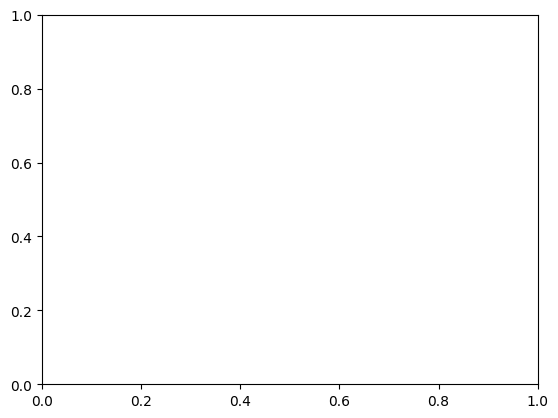

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 117s 2s/step - loss: 0.6982 - accuracy: 0.5505 - val_loss: 0.6702 - val_accuracy: 0.6530
Epoch 2/30
63/63 [==============================] - 119s 2s/step - loss: 0.6914 - accuracy: 0.6095 - val_loss: 0.6527 - val_accuracy: 0.6360
Epoch 3/30
63/63 [==============================] - 123s 2s/step - loss: 0.6355 - accuracy: 0.6450 - val_loss: 0.6483 - val_accuracy: 0.6010
Epoch 4/30
63/63 [==============================] - 110s 2s/step - loss: 0.5910 - accuracy: 0.6920 - val_loss: 0.5989 - val_accuracy: 0.6680
Epoch 5/30
63/63 [==============================] - 109s 2s/step - loss: 0.5484 - accuracy: 0.7285 - val_loss: 0.5920 - val_accuracy: 0.6780
Epoch 6/30
63/63 [==============================] - 105s 2s/step - loss: 0.4996 - accuracy: 0.7555 - val_loss: 0.5431 - val_accuracy: 0.7260
Epoch 7/30
63/63 [==============================] - 107s 2s/step - loss: 0.4664 - accuracy: 0.7775 - val_loss: 0.5193 - val_accuracy: 0.7530
Epoch 8/30
63

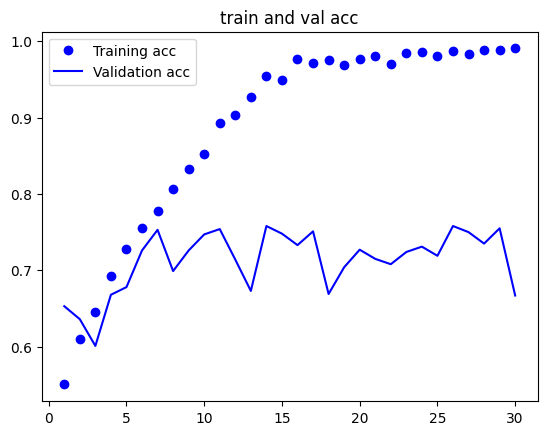

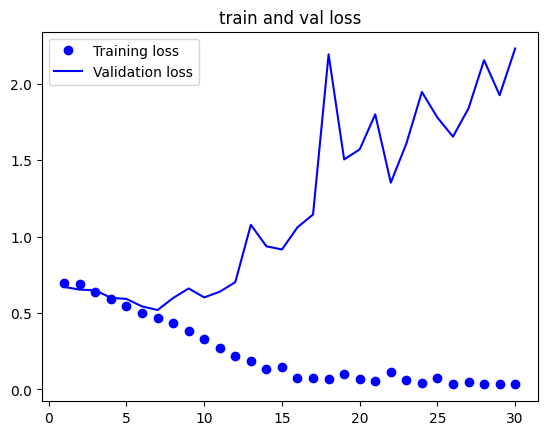

In [38]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training acc")
plt.plot(epochs, val_accuracy, "b", label="Validation acc")
plt.title("train and val acc")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("train and val loss")
plt.legend()
plt.show()

In [136]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 25s 387ms/step - loss: 0.5593 - accuracy: 0.7480
테스트 정확도: 0.748
